In [6]:
"""
Setup Cell - Run this first in every notebook
"""
import sys
import os
import mlflow

# Navigate to project root if in notebooks folder
if 'notebooks' in os.getcwd():
    os.chdir('..')

# Add to Python path
sys.path.insert(0, os.getcwd())

# Set MLflow tracking URI to local server
mlflow.set_tracking_uri("http://localhost:5001")

# Verify setup
print(f"✅ Project root: {os.getcwd()}")
print(f"✅ MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"✅ Data folder exists: {os.path.exists('data')}")
print(f"✅ MLflow server running: Check http://localhost:5001")

✅ Project root: c:\Users\akulc\mlops\MLOps\Labs\mlflow_lab
✅ MLflow tracking URI: http://localhost:5001
✅ Data folder exists: True
✅ MLflow server running: Check http://localhost:5001


🔍 Model Performance Monitoring

1️⃣ Loading test data...
✅ Test set: 1300 samples

2️⃣ Finding best model from MLflow...
✅ Best model: RandomForest
   Run ID: 155a35b500734865a81a5284d32e8e98
   AUC: 0.8993

3️⃣ Recreating best model (fast method)...
✅ Model recreated successfully (much faster than loading!)

4️⃣ Making predictions on test set...
✅ Generated 1300 predictions

5️⃣ Logging monitoring metrics...
✅ Metrics logged to MLflow

6️⃣ Creating monitoring visualizations...


C:\Users\akulc\AppData\Local\Temp\ipykernel_25752\310636417.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='True Class', y='Probability', ax=axes[1, 0], palette='Set2')


   ✅ Dashboard saved to MLflow


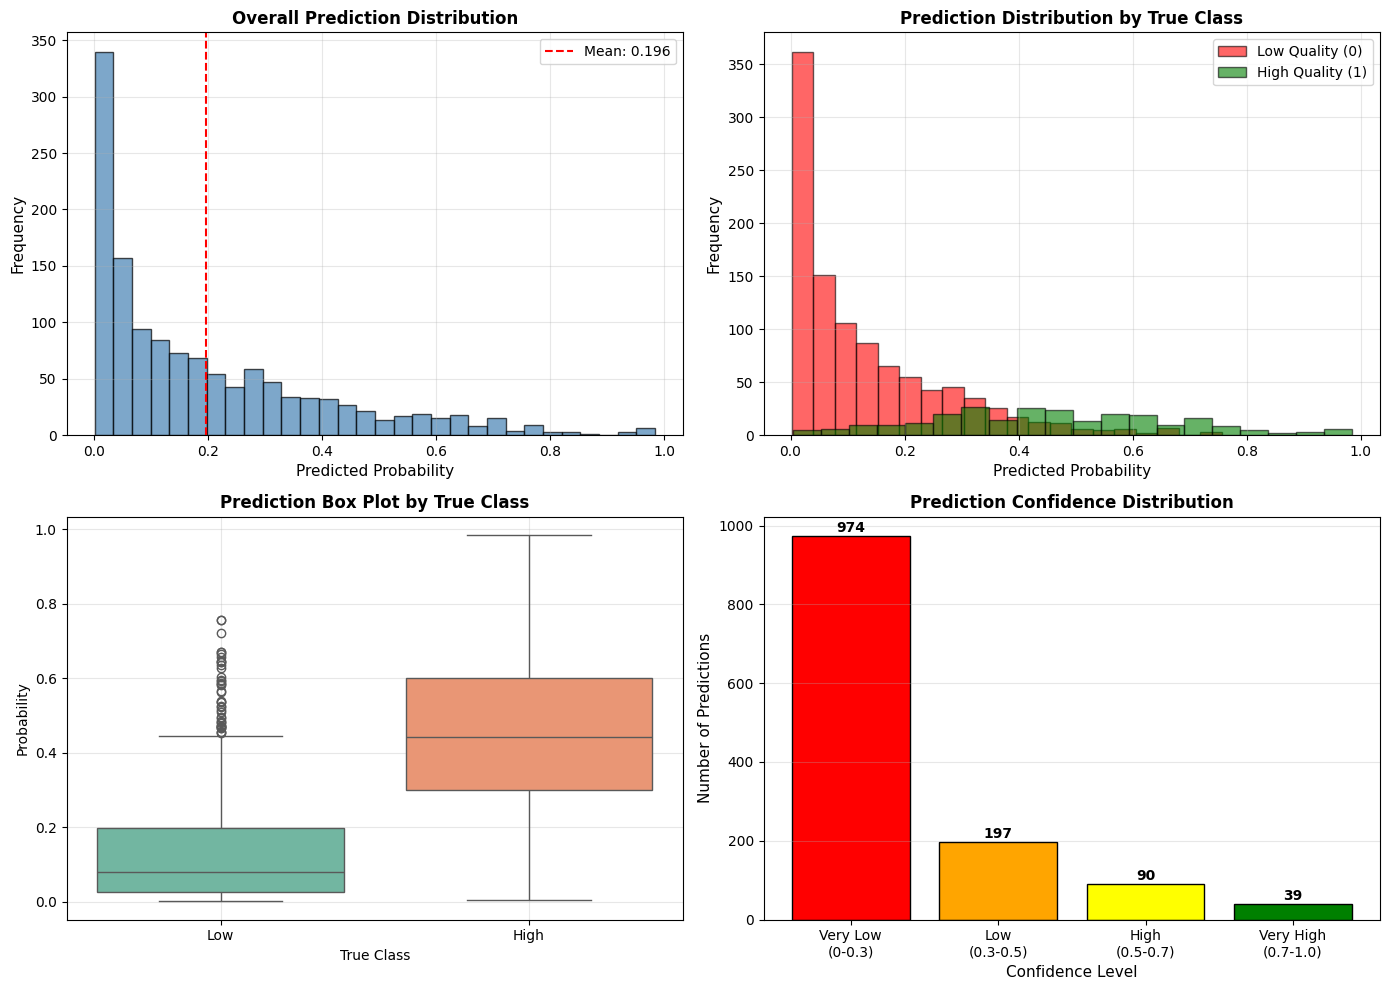


7️⃣ Calibration analysis...
   ✅ Calibration curve saved to MLflow


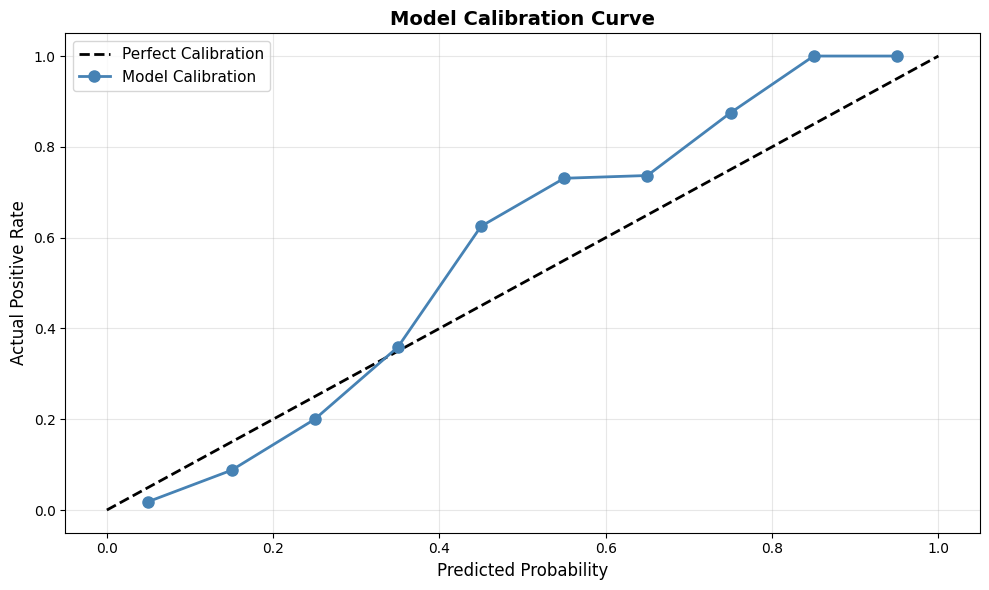


8️⃣ Saving prediction details...
   ✅ Predictions saved to MLflow
   📁 Predictions saved locally: monitoring_predictions.csv

📊 Monitoring Summary:
------------------------------------------------------------
   Total predictions: 1300
   Mean prediction: 0.1962
   Std prediction: 0.2036
   Test AUC: 0.8993
   High confidence predictions: 1013 (77.9%)
   Correct predictions: 1119 (86.1%)

🔍 Misclassification Analysis:
   Total misclassified: 181
   False positives: 27
   False negatives: 154

✅ Monitoring complete!
📊 Check MLflow UI at: http://localhost:5001
📁 Local files generated:
   - monitoring_dashboard.png
   - calibration_curve.png
   - monitoring_predictions.csv
🏃 View run RandomForest_monitoring at: http://localhost:5001/#/experiments/0/runs/9333a68c45fb4a8b84293417fa8e656f
🧪 View experiment at: http://localhost:5001/#/experiments/0


In [9]:
# Model Performance Monitoring
# This notebook monitors model predictions and performance

import sys
import os

# Setup paths
if 'notebooks' in os.getcwd():
    os.chdir('..')
sys.path.insert(0, os.getcwd())

import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from mlflow.tracking import MlflowClient
from src.data_loader import load_wine_data, prepare_classification_data, split_data

# Set MLflow tracking URI
mlflow.set_tracking_uri("http://localhost:5001")

print("🔍 Model Performance Monitoring")
print("=" * 60)

# Load data
print("\n1️⃣ Loading test data...")
data = load_wine_data()
data = prepare_classification_data(data, quality_threshold=7)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data)
print(f"✅ Test set: {len(X_test)} samples")

# Get the best model from MLflow
print("\n2️⃣ Finding best model from MLflow...")
client = MlflowClient()
experiment = mlflow.get_experiment_by_name("wine_quality_comparison")

if experiment is None:
    print("❌ Experiment not found! Please run 02_model_training.ipynb first.")
else:
    # Find best run by AUC
    runs = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["metrics.auc DESC"],
        max_results=1
    )
    
    if len(runs) == 0:
        print("❌ No runs found!")
    else:
        best_run = runs.iloc[0]
        best_model_name = best_run['params.model_type']
        best_auc = best_run['metrics.auc']
        best_run_id = best_run['run_id']
        
        print(f"✅ Best model: {best_model_name}")
        print(f"   Run ID: {best_run_id}")
        print(f"   AUC: {best_auc:.4f}")
        
        # Recreate model (faster than loading from MLflow)
        print("\n3️⃣ Recreating best model (fast method)...")
        
        if best_model_name == 'RandomForest':
            from sklearn.ensemble import RandomForestClassifier
            model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
        elif best_model_name == 'XGBoost':
            import xgboost as xgb
            model = xgb.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, 
                                     objective='binary:logistic', eval_metric='auc', random_state=42)
        elif best_model_name == 'LightGBM':
            import lightgbm as lgb
            model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, 
                                      num_leaves=31, random_state=42)
        elif best_model_name == 'CatBoost':
            from catboost import CatBoostClassifier
            model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, 
                                      random_state=42, verbose=False)
        else:
            # Default to Random Forest if unknown
            from sklearn.ensemble import RandomForestClassifier
            model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
        
        # Train the model
        model.fit(X_train, y_train)
        print("✅ Model recreated successfully (much faster than loading!)")
        
        # Make predictions
        print("\n4️⃣ Making predictions on test set...")
        predictions = model.predict_proba(X_test)[:, 1]
        print(f"✅ Generated {len(predictions)} predictions")
        
        # Create monitoring run
        with mlflow.start_run(run_name=f'{best_model_name}_monitoring'):
            print("\n5️⃣ Logging monitoring metrics...")
            
            # Basic prediction statistics
            mlflow.log_metric('mean_prediction', float(predictions.mean()))
            mlflow.log_metric('std_prediction', float(predictions.std()))
            mlflow.log_metric('min_prediction', float(predictions.min()))
            mlflow.log_metric('max_prediction', float(predictions.max()))
            mlflow.log_metric('median_prediction', float(np.median(predictions)))
            
            # Prediction distribution by class
            high_quality_preds = predictions[y_test == 1]
            low_quality_preds = predictions[y_test == 0]
            
            mlflow.log_metric('mean_pred_high_quality', float(high_quality_preds.mean()))
            mlflow.log_metric('mean_pred_low_quality', float(low_quality_preds.mean()))
            
            # Confidence analysis
            confidence_threshold = 0.7
            high_confidence = (predictions > confidence_threshold) | (predictions < (1 - confidence_threshold))
            mlflow.log_metric('pct_high_confidence', float(high_confidence.mean() * 100))
            
            # Re-calculate AUC
            test_auc = roc_auc_score(y_test, predictions)
            mlflow.log_metric('test_auc', test_auc)
            
            print("✅ Metrics logged to MLflow")
            
            # Visualizations
            print("\n6️⃣ Creating monitoring visualizations...")
            
            # 1. Prediction distribution
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            
            # Histogram
            axes[0, 0].hist(predictions, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
            axes[0, 0].axvline(predictions.mean(), color='red', linestyle='--', 
                              label=f'Mean: {predictions.mean():.3f}')
            axes[0, 0].set_xlabel('Predicted Probability', fontsize=11)
            axes[0, 0].set_ylabel('Frequency', fontsize=11)
            axes[0, 0].set_title('Overall Prediction Distribution', fontsize=12, fontweight='bold')
            axes[0, 0].legend()
            axes[0, 0].grid(alpha=0.3)
            
            # By true class
            axes[0, 1].hist(low_quality_preds, bins=20, alpha=0.6, label='Low Quality (0)', 
                           color='red', edgecolor='black')
            axes[0, 1].hist(high_quality_preds, bins=20, alpha=0.6, label='High Quality (1)', 
                           color='green', edgecolor='black')
            axes[0, 1].set_xlabel('Predicted Probability', fontsize=11)
            axes[0, 1].set_ylabel('Frequency', fontsize=11)
            axes[0, 1].set_title('Prediction Distribution by True Class', fontsize=12, fontweight='bold')
            axes[0, 1].legend()
            axes[0, 1].grid(alpha=0.3)
            
            # Box plot by class
            df_plot = pd.DataFrame({
                'Probability': predictions,
                'True Class': ['High' if x == 1 else 'Low' for x in y_test]
            })
            sns.boxplot(data=df_plot, x='True Class', y='Probability', ax=axes[1, 0], palette='Set2')
            axes[1, 0].set_title('Prediction Box Plot by True Class', fontsize=12, fontweight='bold')
            axes[1, 0].grid(alpha=0.3)
            
            # Confidence levels
            confidence_bins = ['Very Low\n(0-0.3)', 'Low\n(0.3-0.5)', 'High\n(0.5-0.7)', 'Very High\n(0.7-1.0)']
            confidence_counts = [
                ((predictions >= 0) & (predictions < 0.3)).sum(),
                ((predictions >= 0.3) & (predictions < 0.5)).sum(),
                ((predictions >= 0.5) & (predictions < 0.7)).sum(),
                ((predictions >= 0.7) & (predictions <= 1.0)).sum()
            ]
            
            axes[1, 1].bar(confidence_bins, confidence_counts, color=['red', 'orange', 'yellow', 'green'], 
                          edgecolor='black')
            axes[1, 1].set_xlabel('Confidence Level', fontsize=11)
            axes[1, 1].set_ylabel('Number of Predictions', fontsize=11)
            axes[1, 1].set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
            axes[1, 1].grid(axis='y', alpha=0.3)
            
            # Add counts on bars
            for i, count in enumerate(confidence_counts):
                axes[1, 1].text(i, count + 10, str(count), ha='center', fontsize=10, fontweight='bold')
            
            plt.tight_layout()
            plt.savefig('monitoring_dashboard.png', dpi=150, bbox_inches='tight')
            
            # Log artifact with error handling
            try:
                mlflow.log_artifact('monitoring_dashboard.png')
                print("   ✅ Dashboard saved to MLflow")
            except Exception as e:
                print(f"   ⚠️ Could not log to MLflow: {e}")
                print("   📁 Dashboard saved locally: monitoring_dashboard.png")
            
            plt.show()
            
            # 2. Calibration analysis
            print("\n7️⃣ Calibration analysis...")
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Bin predictions and calculate actual rates
            n_bins = 10
            bins = np.linspace(0, 1, n_bins + 1)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            bin_actual = []
            
            for i in range(n_bins):
                mask = (predictions >= bins[i]) & (predictions < bins[i+1])
                if mask.sum() > 0:
                    bin_actual.append(y_test[mask].mean())
                else:
                    bin_actual.append(0)
            
            ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
            ax.plot(bin_centers, bin_actual, 'o-', label='Model Calibration', 
                   linewidth=2, markersize=8, color='steelblue')
            ax.set_xlabel('Predicted Probability', fontsize=12)
            ax.set_ylabel('Actual Positive Rate', fontsize=12)
            ax.set_title('Model Calibration Curve', fontsize=14, fontweight='bold')
            ax.legend(fontsize=11)
            ax.grid(alpha=0.3)
            plt.tight_layout()
            plt.savefig('calibration_curve.png', dpi=150, bbox_inches='tight')
            
            # Log artifact with error handling
            try:
                mlflow.log_artifact('calibration_curve.png')
                print("   ✅ Calibration curve saved to MLflow")
            except Exception as e:
                print(f"   ⚠️ Could not log to MLflow: {e}")
                print("   📁 Calibration curve saved locally: calibration_curve.png")
            
            plt.show()
            
            # 3. Save detailed predictions
            print("\n8️⃣ Saving prediction details...")
            pred_df = pd.DataFrame({
                'true_label': y_test.values,
                'predicted_probability': predictions,
                'predicted_class': (predictions > 0.5).astype(int),
                'correct': (y_test.values == (predictions > 0.5).astype(int)),
                'confidence': np.maximum(predictions, 1 - predictions)
            })
            
            # Add feature values
            for col in X_test.columns:
                pred_df[f'feature_{col}'] = X_test[col].values
            
            pred_df.to_csv('monitoring_predictions.csv', index=False)
            
            # Log artifact with error handling
            try:
                mlflow.log_artifact('monitoring_predictions.csv')
                print("   ✅ Predictions saved to MLflow")
            except Exception as e:
                print(f"   ⚠️ Could not log to MLflow: {e}")
            
            print("   📁 Predictions saved locally: monitoring_predictions.csv")
            
            # Summary statistics
            print("\n" + "=" * 60)
            print("📊 Monitoring Summary:")
            print("-" * 60)
            print(f"   Total predictions: {len(predictions)}")
            print(f"   Mean prediction: {predictions.mean():.4f}")
            print(f"   Std prediction: {predictions.std():.4f}")
            print(f"   Test AUC: {test_auc:.4f}")
            print(f"   High confidence predictions: {high_confidence.sum()} ({high_confidence.mean()*100:.1f}%)")
            print(f"   Correct predictions: {pred_df['correct'].sum()} ({pred_df['correct'].mean()*100:.1f}%)")
            
            # Misclassification analysis
            print("\n🔍 Misclassification Analysis:")
            misclassified = pred_df[~pred_df['correct']]
            print(f"   Total misclassified: {len(misclassified)}")
            print(f"   False positives: {((misclassified['true_label'] == 0) & (misclassified['predicted_class'] == 1)).sum()}")
            print(f"   False negatives: {((misclassified['true_label'] == 1) & (misclassified['predicted_class'] == 0)).sum()}")
            
            print("\n" + "=" * 60)
            print("✅ Monitoring complete!")
            print("📊 Check MLflow UI at: http://localhost:5001")
            print("📁 Local files generated:")
            print("   - monitoring_dashboard.png")
            print("   - calibration_curve.png")
            print("   - monitoring_predictions.csv")

In [3]:
import sys
import os

# Navigate to project root
if 'notebooks' in os.getcwd():
    os.chdir('..')  # Go up one level

# Add to Python path
sys.path.insert(0, os.getcwd())

# Verify
print(f"Current directory: {os.getcwd()}")
print(f"Data file exists: {os.path.exists('data/winequality-white.csv')}")
print(f"Data file exists: {os.path.exists('data/winequality-red.csv')}")

Current directory: c:\Users\akulc\mlops\MLOps\Labs\mlflow_lab
Data file exists: True
Data file exists: True
